# Modèle regression
Ce script a pour but de développer le modèle de deep learning en régression. L'objectif est de labelliser les photos de la queue du RU en renseignant le nombre de personnes dessus.

##### Importation des librairies

In [1]:
import os
import cv2
import time
import numpy as np
from random import randint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### Lecture des données

In [2]:
# Chemin vers les données
PATH_IMG = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/img/"
PATH_LABEL = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/labels/regression"

In [4]:
# VARIABLES GLOBALES
IMAGE_SIZE = 256
BATCH_SIZE = 16
NB_EPOCH = 25

# dataset que l'on souhaite charger en plus des photos initiales
# issues du script d'augmentation de données
data_augmented = {
    'blur': False,
    'contrast': False,
    'brightness': False,
    'noise': True
}

In [5]:
def read_data_folder(path_img, path_labels, img_size=256):
    """
    Lit les images et labels contenus dans un répertoire.
    """
    x_data = list()
    y_data = list()
    
    for file in os.listdir(path_img):
        if not os.path.isfile(os.path.join(path_img, file)):
            continue
        img_name, ext = file.split(".")
        lab_name = str(img_name) + ".txt"
        if lab_name in os.listdir(path_labels):
            # Lecture de l'image
            img_path = os.path.join(path_img, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size)).astype(np.float32)
            # Lecture du label
            with open(os.path.join(path_labels, lab_name), 'r') as file_label:
                label = file_label.read()
            # Ajout de la donnée
            x_data.append(img)
            y_data.append(int(label))
    return x_data, y_data

In [6]:
def load_data(path_img, path_labels, data_augm, img_size=256, normalize=False):
    """
    Lit les images et leur labels, charge optionnellement leurs transformations réalisées lors de 
    l'étape de data augmentation, resize les photos et optionnellement les normalise.
    """
    x_data = list()
    y_data = list()
    print("Lecture des données...")
    # Lecture des données principales
    x, y = read_data_folder(path_img, path_labels)
    x_data.extend(x)
    y_data.extend(y)
    
    # Lecture des dossiers de data_augmentation
    new_path_labels = os.path.join(path_labels, 'data_augmentation')
    if 'blur' in data_augm and data_augm['blur']:
        x, y = read_data_folder(os.path.join(path_img, 'data_augmentation', 'blur'), new_path_labels)
        x_data.extend(x)
        y_data.extend(y)
    if 'contrast' in data_augm and data_augm['contrast']:
        x, y = read_data_folder(os.path.join(path_img, 'data_augmentation', 'contrast'), new_path_labels)
        x_data.extend(x)
        y_data.extend(y)
    if 'brightness' in data_augm and data_augm['brightness']:
        x, y = read_data_folder(os.path.join(path_img, 'data_augmentation', 'brightness'), new_path_labels)
        x_data.extend(x)
        y_data.extend(y)
    if 'noise' in data_augm and data_augm['noise']:
        x, y = read_data_folder(os.path.join(path_img, 'data_augmentation', 'noise'), new_path_labels)
        x_data.extend(x)
        y_data.extend(y)
    
    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)
    
    if normalize:
        m = x_data.mean()
        s = x_data.std()
        x_data -= m
        x_data /= s
    
    print("Nombre de données : {}".format(len(x_data)))
    return x_data, y_data

In [7]:
t1 = time.time()
x_data, y_data = load_data(PATH_IMG, PATH_LABEL, data_augmented, normalize=False, img_size=IMAGE_SIZE)
t2 = time.time()
print("Durée pour lire les données : {}s".format(round(t2-t1, 3)))

Lecture des données...
Nombre de données : 674
Durée pour lire les données : 78.892s


##### Séparation en train et test set

In [8]:
def split_dataset(x_data, y_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                        shuffle=True, test_size=0.2, random_state=123)
    print("Taille set train : {}".format(len(x_train)))
    print("Taille set test : {}".format(len(x_test)))
    return x_train, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = split_dataset(x_data, y_data)

Taille set train : 539
Taille set test : 135


In [22]:
def display_random(data_set):
    i = randint(0, len(data_set)-1)
    img = data_set[i]
    plt.figure(figsize=(10, 10))
    plt.imshow(img.astype(np.uint8), interpolation='nearest')
    plt.axis('off')
    plt.show()
    return img

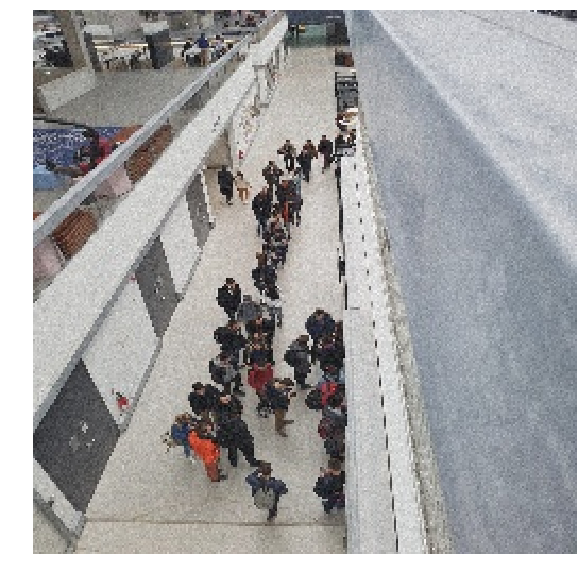

In [11]:
_ = display_random(x_train)

##### Création du modèle de deep learning
Nous avons optimisé les hyper-paramètres du réseau en entrainant plusieurs modèles.
Le modèle ci-dessous resulte de l'optimisation de ceux-ci.

In [12]:
def create_model(input_shape, nb_filters=16, nb_conv=5):

    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(nb_filters*2, kernel_size=(nb_conv, nb_conv), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(nb_filters*2, activation='relu'))
    model.add(Dense(1, activation='linear'))

    adam = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])
    model.summary()
    
    return model

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = create_model(input_shape, nb_filters=32, nb_conv=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 238144)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 238144)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                15241280  
__________

##### Entrainement du modèle crée

In [17]:
def train_model(model, x_train, y_train, batch_size=50, nb_epoch=1000):

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, 
                        validation_split=0.2)

    return history, model

In [18]:
history, model = train_model(model, x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NB_EPOCH)

Train on 431 samples, validate on 108 samples
Epoch 1/25
101s - loss: 113067.9898 - mean_absolute_error: 150.0721 - val_loss: 422.0458 - val_mean_absolute_error: 17.5987
Epoch 2/25
87s - loss: 349.9432 - mean_absolute_error: 14.9164 - val_loss: 119.7639 - val_mean_absolute_error: 9.4568
Epoch 3/25
88s - loss: 169.6284 - mean_absolute_error: 10.5542 - val_loss: 51.7262 - val_mean_absolute_error: 5.3405
Epoch 4/25
92s - loss: 123.9381 - mean_absolute_error: 8.6539 - val_loss: 83.0758 - val_mean_absolute_error: 7.5751
Epoch 5/25
86s - loss: 78.8029 - mean_absolute_error: 6.9728 - val_loss: 27.5796 - val_mean_absolute_error: 4.2581
Epoch 6/25
86s - loss: 58.3909 - mean_absolute_error: 6.1779 - val_loss: 58.9661 - val_mean_absolute_error: 6.6503
Epoch 7/25
92s - loss: 67.1684 - mean_absolute_error: 6.3992 - val_loss: 26.1187 - val_mean_absolute_error: 4.2113
Epoch 8/25
89s - loss: 60.8662 - mean_absolute_error: 6.2970 - val_loss: 20.6000 - val_mean_absolute_error: 3.7683
Epoch 9/25
88s - lo

#### Comparaison de plusieurs modèles
Permettant de comparer la variation des hyper-paramètres du réseau.

In [41]:
def create_multiple_models(input_shape, nb_filters=16, nb_conv=5):
    
    models = []

    for j in [3, 5, 7]:
        model = Sequential()
        model.add(Conv2D(nb_filters, kernel_size=(j, j), strides=(1, 1),
                         activation='relu', padding='valid',
                         input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D(nb_filters*2, kernel_size=(j, j), activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(nb_filters*2, activation='relu'))
        model.add(Dense(1, activation='linear'))

        adam = Adam(lr=0.0001)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])
        models.append(model)
    
    return models

In [42]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
models = create_multiple_models(input_shape, nb_filters=32, nb_conv=5)

##### Entrainement de plusieurs modèles

In [43]:
def train_multiple_models(x_train, y_train, batch_size, nb_epoch, models_to_train):
    histories = list()
    models = list()
    for model in models_to_train:
        history, model = train_model(model, x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch)
        histories.append(history)
        models.append(model)
        print("\n")
    return histories, models

In [44]:
histories, models = train_multiple_models(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NB_EPOCH, 
                                          models_to_train=models)

Train on 215 samples, validate on 54 samples
Epoch 1/25
26s - loss: 83420.3190 - mean_absolute_error: 113.3937 - val_loss: 1354.8335 - val_mean_absolute_error: 30.5929
Epoch 2/25
25s - loss: 994.1364 - mean_absolute_error: 25.2003 - val_loss: 1354.8314 - val_mean_absolute_error: 30.5929
Epoch 3/25
25s - loss: 994.1311 - mean_absolute_error: 25.2002 - val_loss: 1354.8211 - val_mean_absolute_error: 30.5927
Epoch 4/25
25s - loss: 994.1210 - mean_absolute_error: 25.2000 - val_loss: 1354.8069 - val_mean_absolute_error: 30.5925
Epoch 5/25
25s - loss: 994.1085 - mean_absolute_error: 25.1998 - val_loss: 1354.7908 - val_mean_absolute_error: 30.5922
Epoch 6/25
25s - loss: 994.0947 - mean_absolute_error: 25.1995 - val_loss: 1354.7728 - val_mean_absolute_error: 30.5919
Epoch 7/25
25s - loss: 994.0791 - mean_absolute_error: 25.1992 - val_loss: 1354.7529 - val_mean_absolute_error: 30.5916
Epoch 8/25
25s - loss: 994.0623 - mean_absolute_error: 25.1988 - val_loss: 1354.7317 - val_mean_absolute_error: 

65s - loss: 16.6438 - mean_absolute_error: 3.1259 - val_loss: 36.9244 - val_mean_absolute_error: 3.7666
Epoch 20/25
64s - loss: 18.4735 - mean_absolute_error: 3.2977 - val_loss: 46.9622 - val_mean_absolute_error: 4.2173
Epoch 21/25
64s - loss: 18.3987 - mean_absolute_error: 3.2762 - val_loss: 36.7446 - val_mean_absolute_error: 3.7318
Epoch 22/25
64s - loss: 16.7907 - mean_absolute_error: 3.1147 - val_loss: 35.8691 - val_mean_absolute_error: 3.8059
Epoch 23/25
64s - loss: 20.2677 - mean_absolute_error: 3.4763 - val_loss: 41.9982 - val_mean_absolute_error: 4.1732
Epoch 24/25
64s - loss: 18.2410 - mean_absolute_error: 3.4550 - val_loss: 52.2415 - val_mean_absolute_error: 4.7792
Epoch 25/25
64s - loss: 13.3587 - mean_absolute_error: 2.7955 - val_loss: 36.0367 - val_mean_absolute_error: 3.8321




#### Affichage des courbes d'entrainement

In [19]:
def plot_curves_train(history, offset=0, title_name=""):
    # summarize history for accuracy
    plt.figure(figsize=(15, 6))
    plt.plot(list(range(offset, len(history.history['mean_absolute_error']))), 
             history.history['mean_absolute_error'][offset:])
    plt.plot(list(range(offset, len(history.history['val_mean_absolute_error']))), 
             history.history['val_mean_absolute_error'][offset:])
    plt.title('model error for {}'.format(title_name))
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(15, 6))
    plt.plot(list(range(offset, len(history.history['loss']))), 
             history.history['loss'][offset:])
    plt.plot(list(range(offset, len(history.history['val_loss']))), 
             history.history['val_loss'][offset:])
    plt.title('model loss for {}'.format(title_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [45]:
def plot_multiples_curves(histories, offset=0):
    plt.figure(figsize=(15, 6))
    for i in range(len(histories)):
        plt.plot(list(range(offset, len(histories[i].history['val_mean_absolute_error']))), 
                 histories[i].history['val_mean_absolute_error'][offset:])
    plt.title('model error')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['3', '5', '7'], loc='upper right')
    plt.show()

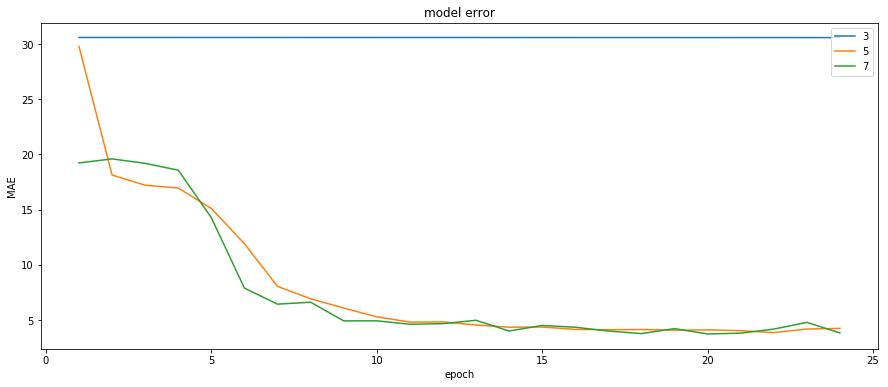

In [46]:
plot_multiples_curves(histories[0:], offset=1)

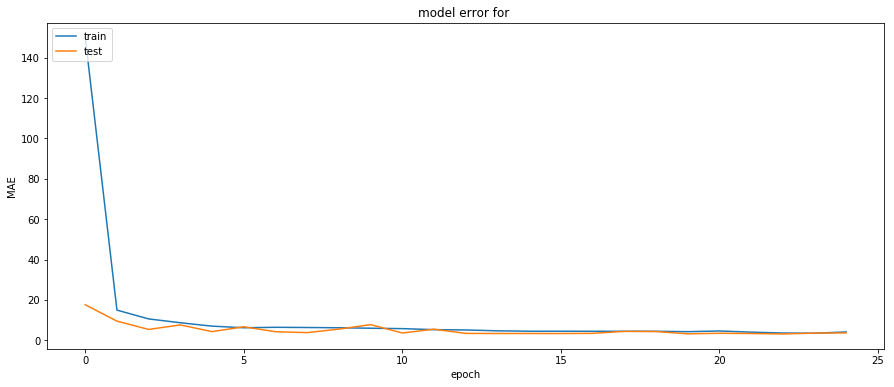

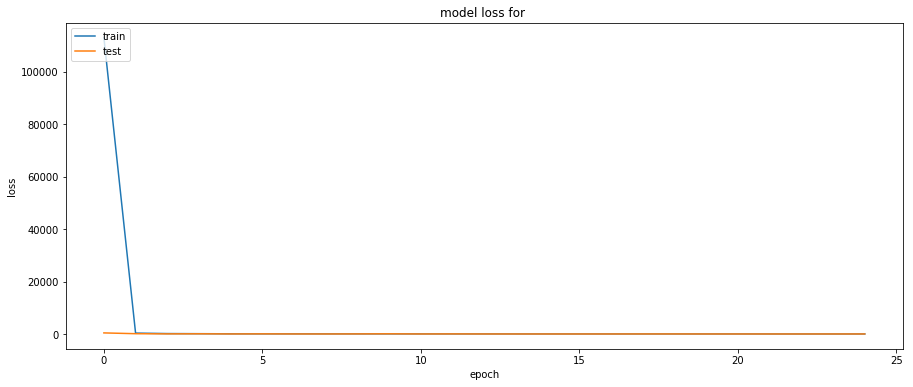

In [20]:
plot_curves_train(history, offset=0, title_name="")

##### Prédictions sur les données de test et évaluation

In [21]:
prediction = model.predict(x_test)
prediction = prediction.reshape(1, -1)[0]
print(prediction)
print(y_test)

MSE = mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)

print("\nMSE : {}".format(round(MSE, 3)))
print("R2 : {}".format(round(R2, 3)))

[6.31403160e+01 1.14271679e+01 4.44346924e+01 4.04170418e+01
 1.37520866e+01 1.35373411e+01 3.21545372e+01 4.09108162e+01
 5.35767212e+01 1.66166134e+01 3.40971112e+00 9.18514824e+00
 8.85954571e+00 1.51491871e+01 9.52187920e+00 9.23998165e+00
 3.66178932e+01 3.75143547e+01 3.39383163e+01 2.25752811e+01
 4.69438286e+01 5.37068292e-04 8.05735874e+00 1.43002319e+01
 3.75170212e+01 6.01988373e+01 3.81805092e-01 5.63061829e+01
 3.16959238e+00 8.76997375e+00 9.64181042e+00 4.94754677e+01
 3.83465271e+01 1.04622698e+01 2.48419437e+01 1.20229702e+01
 5.99824944e+01 3.69212341e+01 2.43720531e+01 4.39152002e+00
 6.08514938e+01 5.37068292e-04 2.57038879e+01 4.36985397e+01
 1.32134581e+01 4.27054367e+01 1.29092283e+01 2.23443508e+00
 4.68915701e+00 2.95794621e+01 1.11594563e+01 5.37068292e-04
 3.63866005e+01 8.92504311e+00 2.12663975e+01 1.64094448e+01
 6.23017216e+00 4.06989174e+01 1.66554141e+00 4.73786306e+00
 4.41201630e+01 3.71120911e+01 2.06473637e+01 5.61588745e+01
 1.47278290e+01 1.421062